# Cvičení 04 — Optimalizátory MLP

O co tady jde:
- toto je rozšíření předchozího cvičení dle druhé části předchozí přednášky.
  - přidáváme představené solvery
  - porovnáváme je

## 0) Jupyter rychlostart (1–2 min)
- Spuštění buňky: **Shift+Enter**
- Přepnutí buňky na kód / markdown: **Y/M** (v command módu)
- Vložit buňku pod: **B**, smazat: **DD**

## 1) Knihovny a nastavení
Použijeme `numpy` a `matplotlib`. Pro dataset **Two Moons** se pokusíme použít `sklearn`, ale máme i NumPy fallback.

In [96]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.datasets import make_moons
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

np.set_printoptions(suppress=True, linewidth=120, precision=4)

## 2) Aktivační funkce a jejich derivace
Implementace nových aktivací: **ReLU, softplus, Leaky ReLU, Swish, ELU**.

In [99]:
class Activation:
    """ Obecná třída pro aktivační funkce s cache pro backprop. """
    def __call__(self, z):
        raise NotImplementedError
    
    def backward(self, dL_da):
        # dL/dz = dL/da * da/dz 
        return dL_da * self.da_dz

class Sigmoid(Activation):
    """ Sigmoid: a = 1 / (1 + e^-z) """
    def __call__(self, z):
        a = 1.0 / (1.0 + np.exp(-z))
        self.a = a 
        self.da_dz = a * (1.0 - a)
        return a

class ReLU(Activation):
    """ ReLU: a = max(0, z) """
    def __call__(self, z):
        a = np.maximum(0, z)
        self.da_dz = (z > 0).astype(float) # Derivace je 1 pro z > 0, 0 pro z <= 0
        return a

class LeakyReLU(Activation):
    """ Leaky ReLU: a = max(alpha * z, z), alpha = 0.01 """
    def __init__(self, alpha=0.01): self.alpha = alpha
    def __call__(self, z):
        a = np.maximum(self.alpha * z, z)
        self.da_dz = np.where(z > 0, 1.0, self.alpha)
        return a
    
class Softplus(Activation):
    """ Softplus: a = ln(1 + e^z). Derivace je Sigmoid. """
    def __call__(self, z):
        # np.log1p(x) = log(1+x)
        a = np.log1p(np.exp(z))
        self.da_dz = 1.0 / (1.0 + np.exp(-z)) # Derivace Softplus je Sigmoid
        return a
    
class Swish(Activation):
    """ Swish (SiLU): a = z * sigmoid(z) """
    def __init__(self): self.sigmoid = Sigmoid() 
    def __call__(self, z):
        a_sig = self.sigmoid(z) # Voláme Sigmoid k získání 'a' a uložení cache
        a = z * a_sig
        # Derivace: a_sig + z * a_sig * (1 - a_sig) = a_sig + a * (1 - a_sig)
        self.da_dz = a_sig + a * (1.0 - a_sig)
        return a
    
class ELU(Activation):
    """ ELU: a = z if z > 0, a = alpha * (e^z - 1) if z <= 0 """
    def __init__(self, alpha=1.0): self.alpha = alpha
    def __call__(self, z):
        a = np.where(z > 0, z, self.alpha * (np.exp(z) - 1))
        # Derivace: 1 if z > 0, a + alpha if z <= 0
        self.da_dz = np.where(z > 0, 1.0, a + self.alpha)
        return a


Tato funkce vykreslí aktivační funkci a její derivaci.

In [102]:
def plot_activation(name, activation_fn, z_values):
    """Vykreslí aktivační funkci a její derivaci."""
    
    # 1. Spočítá aktivační hodnoty 'a'. Toto volání také uloží 'da_dz' do cache instance.
    a_values = activation_fn(z_values)
    
    # 2. Načte derivaci z cache (da_dz)
    da_dz_values = activation_fn.da_dz

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{name} Activation Function and Derivative', fontsize=16)

    # Plot Activation (a)
    ax[0].plot(z_values, a_values, label=f'a = {name}(z)')
    ax[0].set_title('Activation Function (a)')
    ax[0].set_xlabel('z (Input)')
    ax[0].set_ylabel('a (Output)')
    ax[0].grid(True)
    ax[0].legend()

    # Plot Derivative (da/dz)
    ax[1].plot(z_values, da_dz_values, label=f'da/dz = {name}\'(z)', color='red')
    ax[1].set_title('Derivative (da/dz)')
    ax[1].set_xlabel('z (Input)')
    ax[1].set_ylabel('da/dz (Gradient)')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Vytvoříme vstupní data a instance všech aktivačních funkcí.

Spustíme vykreslení pro každou aktivaci.

## 3) Optimalizátory (Solvers)
Implementace optimalizačních algoritmů, které řídí aktualizaci vah.

In [124]:
class Optimizer:
    """Základní třída pro optimalizátory."""
    def __init__(self, lr):
        self.lr = lr
        self.state = {} # Ukládá stav pro každý parametr (např. momentum, varianci)

    def update(self, param, grad, name):
        """Metoda pro aktualizaci jednoho parametru (W nebo b)."""
        raise NotImplementedError

class SGD(Optimizer):
    """Stochastic Gradient Descent (standardní SGD, bez Momentum)."""
    def update(self, param, grad, name):
        return param - self.lr * grad

class Momentum(Optimizer):
    """SGD s Momentum."""
    def __init__(self, lr, beta=0.9):
        super().__init__(lr)
        self.beta = beta

    def update(self, param, grad, name):
        if name not in self.state:
            self.state[name] = {'v': np.zeros_like(param)} # 'v' pro velocity
            
        v = self.state[name]['v']
        
        # v = beta * v + (1 - beta) * grad
        # V praxi se často používá zjednodušená verze: v = beta * v + grad
        v = self.beta * v + grad 
        self.state[name]['v'] = v
        
        return param - self.lr * v
    
class AdaGrad(Optimizer):
    """Adaptive Gradient (AdaGrad)."""
    def __init__(self, lr, epsilon=1e-7):
        super().__init__(lr)
        self.epsilon = epsilon
        
    def update(self, param, grad, name):
        if name not in self.state:
            self.state[name] = {'g2': np.zeros_like(param)} # 'g2' pro squared gradient
            
        g2 = self.state[name]['g2']
        g2 += grad ** 2
        self.state[name]['g2'] = g2
        
        # Aktualizace: lr / sqrt(g2 + epsilon) * grad
        adaptive_lr = self.lr / (np.sqrt(g2) + self.epsilon)
        
        return param - adaptive_lr * grad
    
class RMSProp(Optimizer):
    """Root Mean Square Propagation (RMSProp)."""
    def __init__(self, lr, beta=0.9, epsilon=1e-7):
        super().__init__(lr)
        self.beta = beta
        self.epsilon = epsilon
        
    def update(self, param, grad, name):
        if name not in self.state:
            self.state[name] = {'v': np.zeros_like(param)} # 'v' pro squared gradient (variance)
            
        v = self.state[name]['v']
        
        # v = beta * v + (1 - beta) * grad^2
        v = self.beta * v + (1 - self.beta) * (grad ** 2)
        self.state[name]['v'] = v
        
        # Aktualizace: lr / sqrt(v + epsilon) * grad
        adaptive_lr = self.lr / (np.sqrt(v) + self.epsilon)
        
        return param - adaptive_lr * grad
    
class Adam(Optimizer):
    """Adaptive Moment Estimation (Adam)."""
    def __init__(self, lr, beta1=0.9, beta2=0.999, epsilon=1e-7):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0 # Čítač iterací pro bias correction
        
    def update(self, param, grad, name):
        if name not in self.state:
            self.state[name] = {'m': np.zeros_like(param), 'v': np.zeros_like(param)} 
            
        self.t += 1
        m = self.state[name]['m'] # 1. moment (mean)
        v = self.state[name]['v'] # 2. moment (variance)

        # 1. Moment estimates
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
        self.state[name]['m'] = m
        self.state[name]['v'] = v
        
        # 2. Bias correction
        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)
        
        # Aktualizace: lr * m_hat / (sqrt(v_hat) + epsilon)
        return param - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

## 4) Vrstvy MLP
Úprava `Dense` vrstvy: Metoda `step` se nyní mění na apply_grads a deleguje aktualizaci na objekt optimalizátoru

In [127]:
class Dense:
    def __init__(self, in_dim, out_dim, activation=None):
        # Xavier-like init (pro sigmoid/tanh)
        limit = np.sqrt(1.0 / in_dim)
        self.W = np.random.uniform(-limit, limit, (in_dim, out_dim))
        self.b = np.zeros((1, out_dim))
        self.activation = activation
        # cache
        self.x = None; self.z = None; self.a = None
        # grads
        self.dW = np.zeros_like(self.W); self.db = np.zeros_like(self.b)
        
        # NOVÉ: Optimalizátor se nastaví v MLP
        self.optimizer = None 

    def forward(self, x):
        self.x = x
        self.z = x @ self.W + self.b
        if self.activation is None:
            self.a = self.z # Lineární výstup (logity 'z')
        else:
            self.a = self.activation(self.z)
        return self.a

    def backward(self, dL_d_output):
        # dL/d_output je dL/da z další vrstvy NEBO dL/dz z Loss (SoftmaxCE)
        
        is_loss_dz = not isinstance(self.activation, Activation) and dL_d_output.ndim == self.z.ndim
        
        if is_loss_dz or self.activation is None:
            dL_dz = dL_d_output
        else:
            dL_dz = self.activation.backward(dL_d_output)

        self.dW = self.x.T @ dL_dz / self.x.shape[0]
        self.db = np.mean(dL_dz, axis=0, keepdims=True)
        
        dL_dx = dL_dz @ self.W.T
        return dL_dx

    def apply_grads(self):
        """NOVÁ METODA: Aplikuje vypočtené gradienty pomocí optimalizátoru."""
        if self.optimizer is None:
            raise ValueError("Optimizer nebyl nastaven v MLP.")
        
        # Aktualizace W: předává aktuální W a dW (jako 'grad') optimalizátoru
        self.W = self.optimizer.update(self.W, self.dW, f'{id(self)}_W')
        
        # Aktualizace b: předává aktuální b a db (jako 'grad') optimalizátoru
        self.b = self.optimizer.update(self.b, self.db, f'{id(self)}_b')

## 5) Upravená třída MLP
Konstruktor `MLP` nyní přijímá optimalizátor a předává ho do všech vrstev. Metoda `step` je přejmenována na `apply_grads` a volá novou metodu z `Dense`.

In [130]:
class MLP:
    def __init__(self, layers, loss, optimizer=None): # NOVÝ PARAMETR: optimizer
        self.layers = layers
        self.loss = loss
        self.loss_includes_activation = isinstance(loss, SoftmaxCE)
        
        # NOVÉ: Nastavení optimalizátoru pro všechny vrstvy
        self.optimizer = optimizer
        if optimizer is not None:
             for layer in self.layers:
                layer.optimizer = optimizer

    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        return a 

    def predict(self, X):
        y_raw = self.forward(X)
        if self.loss_includes_activation:
            exp_z = np.exp(y_raw - np.max(y_raw, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        else:
            return y_raw

    def backward(self, dL_d_output):
        g = dL_d_output
        for layer in reversed(self.layers):
            g = layer.backward(g)

    def apply_grads(self):
        """NOVÁ METODA pro aplikaci gradientů přes optimalizátor."""
        for layer in self.layers:
            layer.apply_grads()

    def train(self, X, Y, X_val=None, Y_val=None, lr=0.1, epochs=2000, batch_size=None, verbose=False):
        # NOTE: 'lr' v train metodě je nyní obvykle ignorováno, protože je nastaveno v Optimizeru, 
        # ale ponecháme ho pro zpětnou kompatibilitu.
        train_losses = []
        val_losses = []
        n = X.shape[0]
        
        has_val_data = X_val is not None and Y_val is not None

        for ep in range(epochs):
            # ... (zbytek train metody zůstává stejný, jen se změní volání aktualizace) ...
            
            # --- Trénovací fáze (s aktualizací vah) ---
            if batch_size is None or batch_size >= n:
                idx = np.arange(n)
            else:
                idx = np.random.permutation(n)

            ep_loss = 0.0; batches = 0
            for start in range(0, n, batch_size or n):
                end = min(start + (batch_size or n), n)
                bidx = idx[start:end]
                xb, yb = X[bidx], Y[bidx]

                y_raw = self.forward(xb)
                loss, dL_d_output = self.loss(y_raw, yb)
                self.backward(dL_d_output)
                
                # ZMĚNA: Používáme apply_grads přes optimalizátor
                self.apply_grads() 

                ep_loss += loss; batches += 1

            train_losses.append(ep_loss / max(1, batches))

            # --- Validační fáze (pouze výpočet ztráty, bez aktualizace vah) ---
            if has_val_data:
                y_val_raw = self.forward(X_val)
                val_loss, _ = self.loss(y_val_raw, Y_val)
                val_losses.append(val_loss)
            
            if verbose and (ep+1) % max(1, epochs//10) == 0:
                val_output = f" | val_loss={val_losses[-1]:.6f}" if has_val_data else ""
                print(f"epoch {ep+1}/{epochs} | loss={train_losses[-1]:.6f}{val_output}")
                
        return np.array(train_losses), np.array(val_losses)

## 6) Vizualizace — křivka ztráty a rozhodovací hranice
Používá `MLP.predict` pro správnou predikci i v případě SoftmaxCE.

In [133]:
def train_test_split(X, Y, test_size=0.2, seed=42):
    """Rozdělí data na trénovací a testovací množinu."""
    np.random.seed(seed)
    n = X.shape[0]
    n_test = int(n * test_size)
    idx = np.random.permutation(n)
    
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    
    return X[train_idx], X[test_idx], Y[train_idx], Y[test_idx]


def plot_loss(train_losses, val_losses=None, title="Průběh ztráty (Loss)"):
    """Vykreslí trénovací a testovací ztrátu v jednom grafu."""
    plt.figure(); 
    plt.plot(train_losses, label='Trénovací ztráta (Train Loss)')
    
    if val_losses is not None and len(val_losses) > 0:
        plt.plot(val_losses, label='Testovací ztráta (Test/Validation Loss)')
    
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title); plt.legend(); plt.show()

def plot_decision_boundary_2d(model, X, Y, title="Rozhodovací hranice"):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    with np.errstate(over='ignore'):
        zz = model.predict(grid)
        
    # Zpracování výstupu pro rozhodovací hranici
    if zz.ndim == 2 and zz.shape[1] == 1:
        # Binární klasifikace s jedním výstupem (např. LSE + Sigmoid)
        zz = (zz >= 0.5).astype(int)
    elif zz.ndim == 2 and zz.shape[1] > 1:
        # Více-třídní klasifikace (např. SoftmaxCE) - argmax z pravděpodobností
        zz = np.argmax(zz, axis=1)
    else:
        # Regrese nebo jiné případy
        return
    
    zz = zz.reshape(xx.shape)
    plt.figure(); plt.contourf(xx, yy, zz, alpha=0.25, levels=2)
    
    # Nastavení barvy pro Y (konverze one-hot na indexy)
    if Y.ndim == 2 and Y.shape[1] > 1:
        c = np.argmax(Y, axis=1) # Pro one-hot kódování
    elif Y.ndim == 2 and Y.shape[1] == 1:
        c = Y.ravel()
    else: c = Y
        
    plt.scatter(X[:,0], X[:,1], c=c, edgecolors="k")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

def plot_regression_1d(model, Xr, Yr, title="Regrese: sin(2πx)"):
    xs = np.linspace(-1.2, 1.2, 400).reshape(-1,1)
    ys = model.predict(xs)
    plt.figure()
    plt.scatter(Xr, Yr, s=10, alpha=0.6, label="data")
    plt.plot(xs, np.sin(2*np.pi*xs), linestyle="--", label="sin(2πx) — ground truth")
    plt.plot(xs, ys, label="MLP predikce")
    plt.legend(); plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.show()

## 7) Úloha B — **Two Moons** s **SoftmaxCE** a **Swish** aktivací a s optimalizátorem Adam


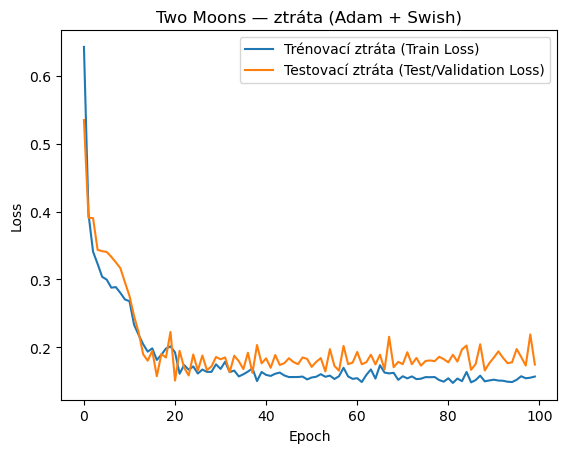

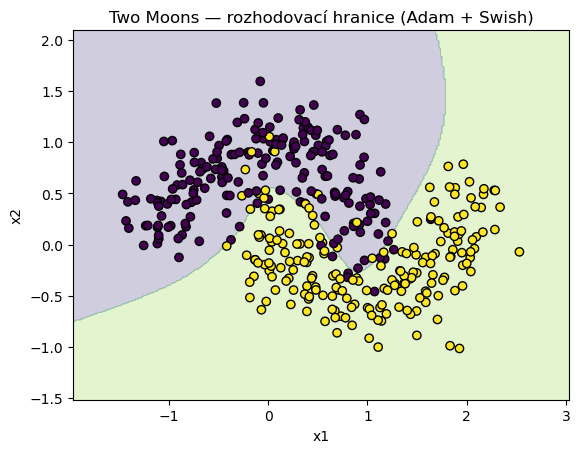

Přibližná testovací přesnost (Adam): 92.5%


In [136]:
# Úprava původní Úlohy B (Two Moons) pro použití optimalizátoru Adam

if SKLEARN_OK:
    from sklearn.preprocessing import OneHotEncoder
    X_moons, y_moons = make_moons(n_samples=400, noise=0.25, random_state=0)
    ohe = OneHotEncoder(sparse_output=False); 
    Y_moons_ohe = ohe.fit_transform(y_moons.reshape(-1,1))
else:
    X_moons, y_moons = make_moons_np(n_samples=400, noise=0.25, seed=0)
    Y_moons_ohe = np.zeros((y_moons.size, 2))
    Y_moons_ohe[np.arange(y_moons.size), y_moons.ravel().astype(int)] = 1

# Rozdělení dat
X_train, X_test, Y_train_ohe, Y_test_ohe = train_test_split(X_moons, Y_moons_ohe, test_size=0.3, seed=42)
y_test_labels = np.argmax(Y_test_ohe, axis=1)

# NOVÁ LOGIKA: Inicializace s Adam optimalizátorem
adam_optimizer = Adam(lr=0.01)

np.random.seed(1)
moons_net = MLP(
    layers=[Dense(2, 16, Swish()), Dense(16, 16, Swish()), Dense(16, 2, None)],
    loss=SoftmaxCE(),
    optimizer=adam_optimizer # PŘEDÁNÍ ADAMU
)
# Trénovací metoda je nyní volána bez LR (protože LR je v Adamu)
losses_train_moons, losses_val_moons = moons_net.train(X_train, Y_train_ohe, 
                                                       X_val=X_test, Y_val=Y_test_ohe, 
                                                       lr=0, epochs=100, batch_size=32, verbose=False)

plot_loss(losses_train_moons, losses_val_moons, title="Two Moons — ztráta (Adam + Swish)")
plot_decision_boundary_2d(moons_net, X_moons, Y_moons_ohe, title="Two Moons — rozhodovací hranice (Adam + Swish)")

pred_test = np.argmax(moons_net.predict(X_test), axis=1)
acc_test = (pred_test == y_test_labels).mean()*100
print(f"Přibližná testovací přesnost (Adam): {acc_test:.1f}%")

## 8) Úloha E: Porovnání optimalizátorů
Nyní můžeme porovnat výkon různých optimalizátorů na datasetu Two Moons.

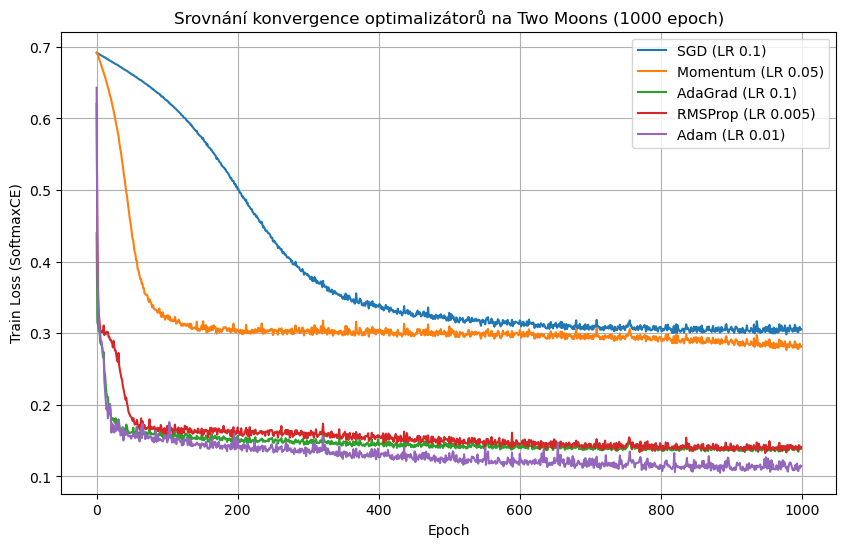

Srovnání optimalizátorů dokončeno. Všimněte si, jak adaptivní metody (Adam, RMSProp) konvergují rychleji.


In [139]:
if SKLEARN_OK and X_moons is not None:
    
    # 1. Příprava dat (použijeme rozdělení z Úlohy B)
    # X_train, X_test, Y_train_ohe, Y_test_ohe
    
    # 2. Definice optimalizátorů k porovnání
    optimizers = {
        "SGD (LR 0.1)": SGD(lr=0.1),
        "Momentum (LR 0.05)": Momentum(lr=0.05, beta=0.9),
        "AdaGrad (LR 0.1)": AdaGrad(lr=0.1),
        "RMSProp (LR 0.005)": RMSProp(lr=0.005, beta=0.9),
        "Adam (LR 0.01)": Adam(lr=0.01, beta1=0.9, beta2=0.999)
    }

    results = {}
    EPOCHS = 1000
    BATCH_SIZE = 32
    
    plt.figure(figsize=(10, 6))

    for name, optimizer in optimizers.items():
        np.random.seed(1)
        
        # Architektura (stejná jako v Úloze B)
        comparison_net = MLP(
            layers=[Dense(2, 16, Swish()), Dense(16, 16, Swish()), Dense(16, 2, None)],
            loss=SoftmaxCE(),
            optimizer=optimizer # PŘEDÁNÍ OPTIMALIZÁTORU
        )
        
        # Trénování s nastaveným optimalizátorem
        train_losses, _ = comparison_net.train(X_train, Y_train_ohe, 
                                                lr=0, # LR se bere z optimizeru
                                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)
        
        results[name] = train_losses
        plt.plot(train_losses, label=name)

    # Vykreslení srovnání
    plt.xlabel("Epoch"); plt.ylabel("Train Loss (SoftmaxCE)"); 
    plt.title(f"Srovnání konvergence optimalizátorů na Two Moons ({EPOCHS} epoch)")
    plt.legend(); plt.grid(True); plt.show()
    
    print("Srovnání optimalizátorů dokončeno. Všimněte si, jak adaptivní metody (Adam, RMSProp) konvergují rychleji.")